# Analysing a detailed single-neuron model with MinimallyDisruptiveCurves.jl
## Dhruva V. Raman 
#### (github: Dhruva2, email: dvr23@cam.ac.uk)

### Introduction
- We will take a model of a bursting pacemaker neuron in the stomatogastric ganglion of a lobster, and analyse it.
- The model is taken from [here](https://www.jneurosci.org/content/18/7/2309.short)
- I will analyse the model as if I **don't** have intuition on the model, **nor** any scientific question to answer. I just want to do an exploratory analysis. Thus I don't investigate particular hypotheses/parameters. 
- If I had particular scientific questions, the workflow would look different: this will be covered in a later notebook. 
- I will do my analysis using a fast but inaccurate **collocation cost** on the model output (explained later). Just so you know it exists. I'll analyse the same model with a more standard (L2) cost later on.

### What is done in this notebook

#### 1. Load STG neuron model
- The ODE model is of the form: $\dot{x} = f(x, p, u, t)$. Here, $x(t)$ is the vector of states at time $t$, consisting of membrane voltage, calcium concentration, and the various ion channel permeabilities.
- $p$ are the parameters. $p_0$ are the initial (best-fit) parameters. $t$ is time.
- $u(t)$ is an autonomous current input to the neuron. For this example we take $u(t) = 0$ for simplicity. In later examples we construct libraries of inputs, with model performance measured with respect to each input.

#### 2. Build a cost function of the form:

$$ C(p) = \int^T_0 \| f(x^*(t), \theta, t) - f(x^*(t), \theta^*, t)\|_2^2 \ dt $$

- We are matching the **derivatives** of the nominal and parameter-varying trajectories in the cost. This is often known as the **collocation** cost. 
- Why? This is sometimes a useful 'rough and ready' cost function to start with. Evaluation of this cost and its gradient doesn't require differentating through the solution of a differential equation. So it's millisecond level speed on my laptop. 
- However, this type of cost can become less meaningful when it's at a higher value. 
- We will also investigate the model using a more traditional, slower, L2 cost function in another notebook, to get further insight not possible here. 



#### 3. Generate initial curve directions for the minimally disruptive curves
by solving the nonconvex, quadratically constrained quadratic program:

$$ \min_x x^T H x + \lambda \| x \|_1 : \quad x^Tx = 1,$$ 
where $H$ is the hessian, and $\lambda = 1$ is a regularisation hyperparameter.
- This uses a simple approx 20 line function `sparse_init_dir` included in helper_functions.jl. 
- We set $\lambda = 1.$. This $\mathcal{L}_1$ regularisation term enforces sparsity, so the initial curve directions only involve a few parameters at a time.
- This is **nonconvex**, with multiple local solutions. By randomising the initial conditions of the optimisation, we get many different solutions corresponding to different promising initial curve directions. 
- We removed duplicate solutions and selected the 5 best directions

#### 4. Generate 5 minimally disruptive curves corresponding to each of the 5 best initial curve directions.
- You can run the nth curve yourself by reassigning `which_dir = n`. 
- Evolving a curve should take 1/2 mins max. 


#### 5. **Cursory scientific analysis of the curves is provided at the bottom of the notebook**. 

## The code

### Section 1
- import packages
- import model
- simulate and plot model

In [1]:
using MyModelMenagerie, OrdinaryDiffEq, MinimallyDisruptiveCurves, Plots, DiffEqParamEstim, DiffEqSensitivity, LinearAlgebra

In [ ]:
include("helper_functions.jl");
alg = Vern9 #or eg Tsit5, used for solving ODE
solve = OrdinaryDiffEq.solve #because it clashes with JuMP.solve

In [3]:
od,ic,_ , ps = CalciumNeuron(t->0.);
tspan = (0,500.);
tsteps = 0.:10.:500; #at which to measure model output

In [4]:
prob = ODEProblem(od,ic,tspan,ps)
p0 = last.(ps);

In [ ]:
sol = solve(prob, alg())
pnom = plot(sol);
plot(sol)
# savefig(pnom, "nominal_solution_stg.png")

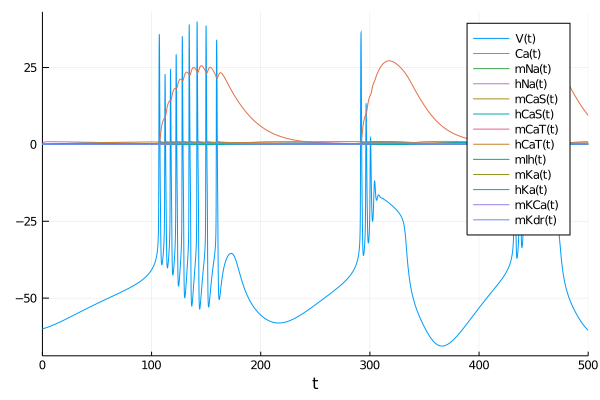

### Section 2
- build collocation cost using the function build_injection_loss()
- Use Forward mode automatic differentiation to get the hessian
- generate potential directions by solving the QCQP defined in the introduction, 100 times. Random initialisation of the initial guess + nonconvexity means that each solution is different. We then prune duplicates and order the solutions in terms of how good they are

In [ ]:
cost = build_injection_loss(prob,alg(),tsteps)
using ForwardDiff
@time hess = ForwardDiff.hessian(cost, p0);

In [ ]:
potential_dirs = [sparse_init_dir(hess)[1] for i = 1:10]
pd_projs = [el'*hess*el for el in potential_dirs]; # ie how good is each guess
inds = sortperm(pd_projs) # sort in order
potential_dirs = potential_dirs[inds];

In [9]:
duplicates = [] # remove potential_directions that are approximately equal (norm(a-b) < 1e-5) to previous directions
for (i,el) in enumerate(potential_dirs)
    for (j,comp) in enumerate(potential_dirs[i+1:end])
        if ((norm(el - comp) < 1e-2) || (norm(el + comp) < 1e-2))
            push!(duplicates, i+j)
        end
    end  
end
potential_dirs[unique(duplicates)]
potential_dirs = potential_dirs[setdiff(1:length(potential_dirs), duplicates)];

### Section 3
- Now we set ```which_dir=n``` to generate the minimally disruptive curve generated by the nth direction in potential_dirs
- Other hyperparameters are spans (distances to evolve curve over), and moms (momenta of each curve). These are tuples, with entries for each which_dir.
- Then we generate the MD curve.

In [10]:
which_dir = 1;
spans = [(-50., 50.), (-50., 50.), (-50., 50.), (-50., 50.), (-50., 50.)
]
moms = [1., 1., 1., 1., 1.];

In [16]:
dp0 = potential_dirs[which_dir]
mom = moms[which_dir] 
span = spans[which_dir]
eprob = MDCProblem(cost, p0, dp0, mom, span);

In [ ]:
@time mdc = evolve(eprob, Tsit5);

In [ ]:
s = 40
ss = check_sol_at_dist(s,prob, mdc)
p1 = plot(ss)
p2 = solve(prob, alg()) |> plot
pp = plot(p1,p2, layout = (2,1))

In [14]:
# p = disp_mdc(mdc, ps)
# savefig(p, "stg_injection_loss$(which_dir).png")

# Analysing the Minimally Disruptive Curve outputs

- You can generate the nth curve yourself by running the code above, and setting which_dir = n. 
- Here I generate and analyse the first 5 curves.
- Note that in each curve, **all** parameters of the model are free to vary. I used the purely automatic initial direction selection given in the code above. So generation of the curves required no domain knowledge.
- However, I only graphed the 5 biggest changing parameters (over the curve), to avoid cluttering the figures.
- In general, domain knowledge might be used to infer free parameters and promising initial curve directions.

**Note**: If you want to check what the perturbed dynamics of the model look like at some point along the curve, run the code below (s is the distance on the curve). I promise you \emph{a priori} they will look visually identical to the dynamics of the original model! I demonstrate this on the first curve, but not subsequently.

In [15]:
check_sol_at_dist(s, prob, mdc)

LoadError: UndefVarError: mdc not defined

## Curve 1
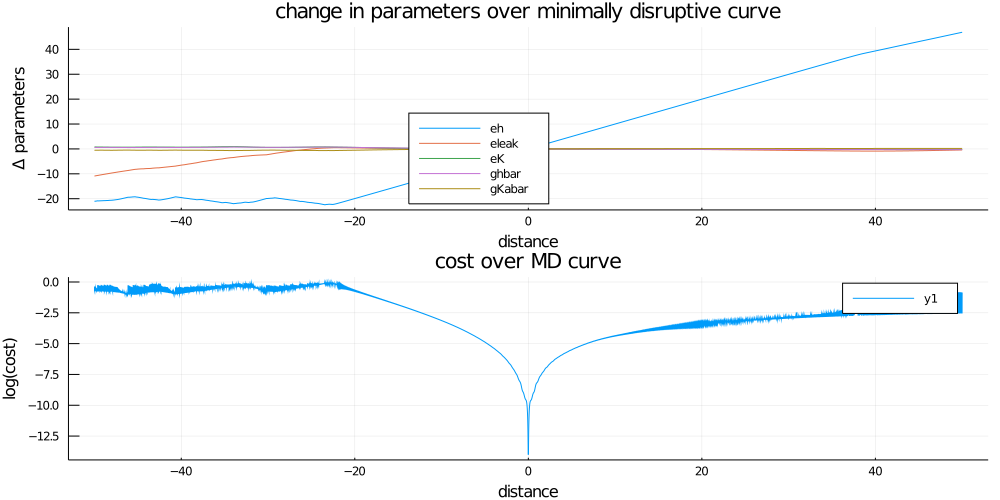

### Interpretation:
Pretty straightforward!
- Increase $eh$ by quite a lot before any measurable effect on dynamics is felt
- Decrease $eh$ by less
To give an idea of what constitutes "measurable effect", we can run the code below, to simulate the model at the user's choice of distance $s$. 
- If we decided we wanted a little more give in the model, we would increase the momentum hyperparameter. Then the curve would travel for further before curving as a result of increasing cost.

**To give you an idea** of how much "cost = x" actually changes dynamics, we have plotted in this case the side-by-side simulations of the nominal model, and the perturbed model along this MDC at distance = 45. Where the cost is about 0.5. I can't see (visually) any difference. So this is pretty small. Note that none of the curves in this notebook go above cost 1, which can be interpreted as: " **at no point on any of these minimally disruptive curves do the dynamics change enough that there is a noticeable visual difference on a plotted graph".

- But feel free to test for yourself, by copying the below code and changing the value of $s$!

Other questions you could ask:
- Can we rerun  the curve, but increasing numerical accuracy, by fixing all the parameters except $eh$ and/or $eleak$?

- What happens to the curve if we rerun, setting the kwarg: `momentum_tol = 1e-2`? (for example, or you could set it to e.g. 1e-5)?

s = 45
s_sol = check_sol_at_dist(s, prob, mdc)
p1 = plot(s_sol)
p2 = plot(sol)
p = plot(p1,p2, layout=(2,1))
savefig(p, "stg_injection_mdc1_comparison.png")

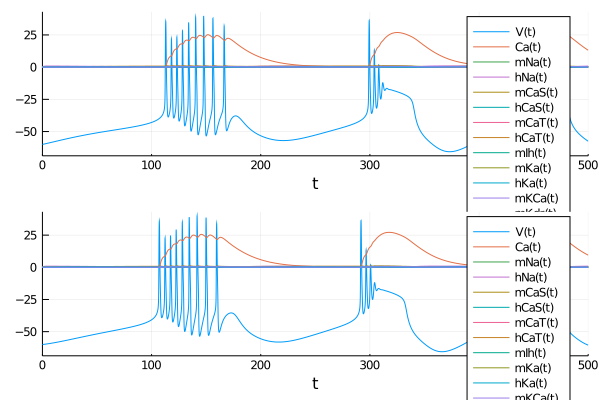

## Curve 2
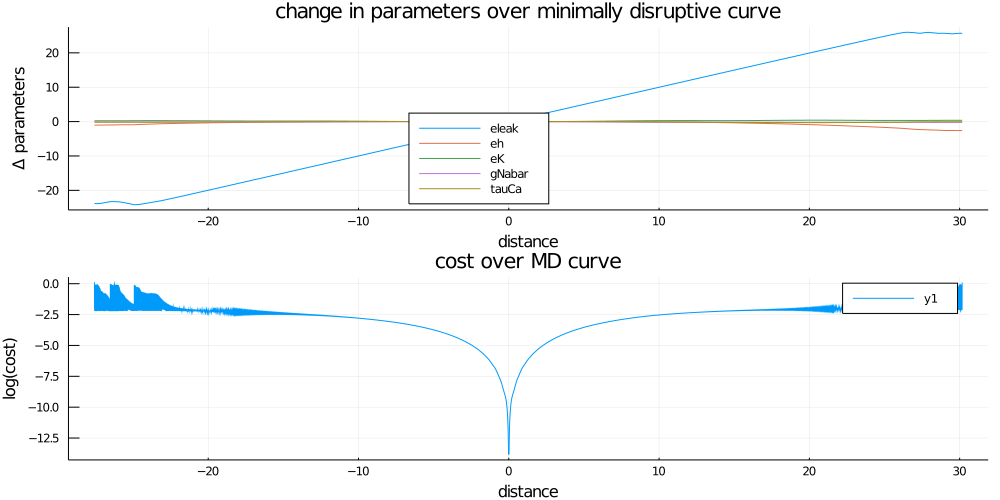

### Interpretation

Again, pretty straightforward: $e_{leak}$ can be perturbed a fair amount (increase or decrease) without any noticeable effect on dynamics.

Maybe I'm interested in whether I can get even larger changes in $eh$ and $eleak$ if they co-vary. It's quite simple to do this: just set the initial starting direction so it involves these parameters. In general, you could solve an optimisation problem like:

$$ min_x x^T H x - \|x_i\|_2^2 - \| x_j \|_2^2 + \lambda \| x \|_1 : x^Tx = 1, $$
where $i$ and $j$ (and others if you require) are the indices of the variables you want to include in the starting direction. So $eh$ and $eleak$ in this case. You can modify the code in sparse_init_dirs() appropriately to do this. We won't here, as the notebook is long enough!

## Curve 3
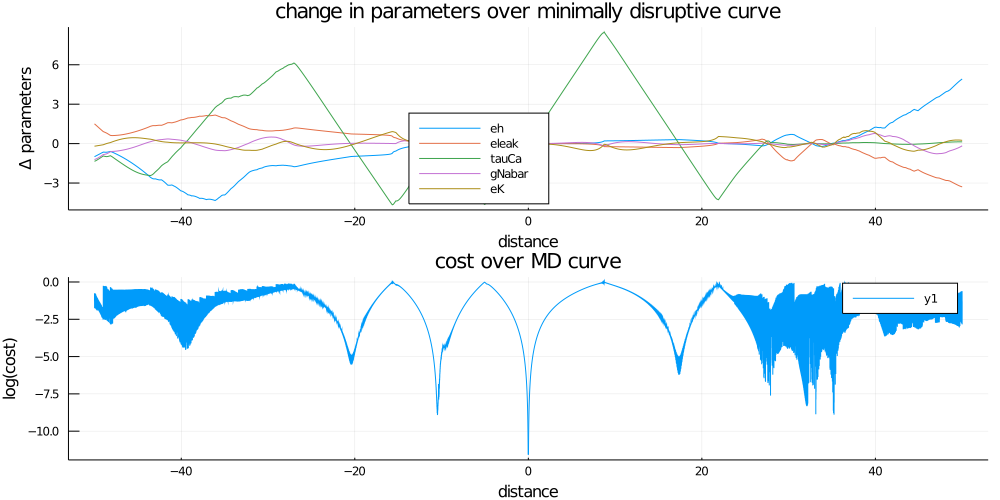

#### Interpretation

Yikes, what happened here? 
1. The algorithm had to keep resetting the costate (i.e. momentum) of the curve. 
2. This prevents the curve from monotonically increasing its distance from the nominal set of parameters (something I plan to fix in later iterations of this package).
3. We have a "see-sawing" effect. 

Nevertheless, we see how much tauCa can be varied without greatly affecting dynamics

## Curve 4
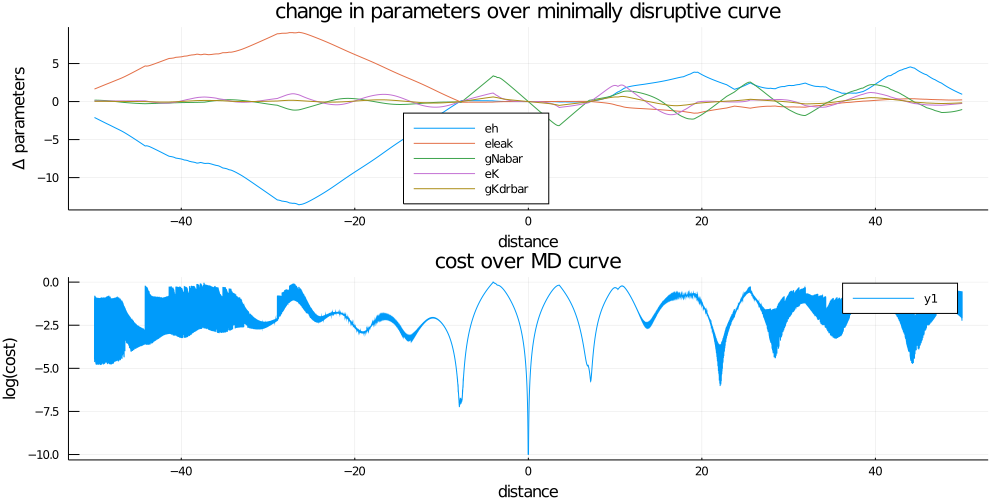

### Interpretation
These automatically generated curves are no longer telling us anything particularly important and new. Time to more intelligently pick our cost functions and/or initial directions!